In [1]:
import sys
sys.path.append('/home/dof6/Desktop/Pose-Estimation-for-Sensor-Calibration')
import cv2

import numpy as np
import os
import glob
# import pickle

# import rospy
from ur_msgs.srv import JointTrajectory, EndPose, JointStates

from matplotlib import pyplot as plt
from utils_realsense import RealSenseSensor

sys.path.append('/usr/lib/python2.7/dist-packages')
from utils_ur5 import *

In [2]:
realsense = RealSenseSensor("141322252613") # put your serial number here
K_rs = realsense._color_intrinsics
D_rs = 0

In [3]:
planUR5 = rospy.ServiceProxy('plan_robot_arm', JointTrajectory)
moveUR5 = rospy.ServiceProxy('move_robot_arm', JointTrajectory)
getEEFPose = rospy.ServiceProxy('get_eef_pose', EndPose)
getJointStates = rospy.ServiceProxy('get_joint_states', JointStates)

In [4]:
rospy.wait_for_service('plan_robot_arm')
rospy.wait_for_service('move_robot_arm')
rospy.wait_for_service('get_eef_pose')
rospy.wait_for_service('get_joint_states')

In [5]:
ARM_JOINT_NAME = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
ROBOT_INIT_POS = [0.0, -0.3, 0.65]
ROBOT_INIT_ROTATION = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])

In [6]:
color, depth = realsense.frames(spatial=True, hole_filling=True, temporal=True)

In [7]:
def get_joint_states():
    joints_Str = getJointStates().joint_states.replace('(', '').replace(')', '').split(', ')
    joints = [float(j) for j in joints_Str]
    return joints

In [8]:
def get_eef_pose():
    pose = getEEFPose().eef_pose
    position = [pose.position.x, pose.position.y, pose.position.z]
    quaternion = [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w]
    return position, quaternion

In [9]:
def get_view(goal_pos=None, quat=[1, 0, 0, 0], grasp=0.0, show_img=False):
    # quat: xyzw
    if goal_pos is not None:
        plans = moveUR5(ARM_JOINT_NAME, None, goal_pos, quat, 1-grasp)
        if len(plans.plan.points)<=1:
            print("Failed planning to the goal.")
            current_pos, current_quat = get_eef_pose()
            subgoal_pos = (np.array(goal_pos) + np.array(current_pos))/2
            print('current:', current_pos)
            print('sub goal:', subgoal_pos)
            print('goal:', goal_pos)
            sub_plans = moveUR5(ARM_JOINT_NAME, None, subgoal_pos, current_quat, 1-grasp)
            rospy.sleep(1.5)
            plans = moveUR5(ARM_JOINT_NAME, None, goal_pos, quat, 1-grasp)
            if len(plans.plan.points)<=1:
                print("Failed planning to the sub-goal.")
                return False
    rospy.sleep(0.5)
    color, depth = realsense.frames(spatial=True, hole_filling=True, temporal=True)
    if show_img:
        plt.imshow(color)
        plt.show()
    return color, depth

In [10]:
CHECKERBOARD = (6, 9)
def get_cam_theta_p(color, show_img=True):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    if show_img:
        plt.imshow(img)
        plt.show()
    return R_vec_cam_to_chess, p_cam_to_chess

def get_cam_R_T(color, show_img=True):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    if show_img:
        plt.imshow(img)
        plt.show()
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    R_cam_to_chess, _ = cv2.Rodrigues(R_vec_cam_to_chess)
    T_cam_to_chess = form_T(R_cam_to_chess, p_cam_to_chess)
    return R_cam_to_chess, T_cam_to_chess

In [11]:
float(getJointStates().joint_states.split(',')[5])

2.7891931533813477

In [12]:
getEEFPose()

eef_pose: 
  position: 
    x: -0.001218626238829916
    y: -0.33168930946669467
    z: 0.5156044748872473
  orientation: 
    x: 0.9999916906678211
    y: 0.0016177611109037893
    z: -0.0026864831212153216
    w: -0.0026046598127854696

In [13]:
getJointStates()

joint_states: "(-1.9197691122638147, -1.949592415486471, 1.649116039276123, -1.2665370146380823,\
  \ 4.723473072052002, 2.7891931533813477, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"

In [14]:
ROBOT_INIT_POS

[0.0, -0.3, 0.65]

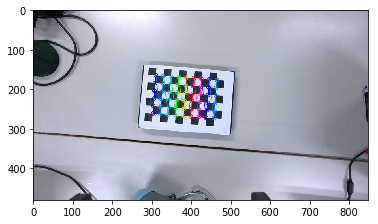

[[ 7.74017035e-02 -9.96958934e-01  9.04762451e-03 -4.23639702e-02]
 [ 9.96999687e-01  7.73914393e-02 -1.47964519e-03  4.84988746e-02]
 [ 7.74936805e-04  9.13500586e-03  9.99957975e-01 -5.37281801e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [15]:
img, _ = get_view(ROBOT_INIT_POS, grasp=0.0) # grasp=1.0
R, T = get_cam_R_T(img)
print(np.linalg.inv(T))

In [16]:
# new frame init pose: [-0.0281, -0.2988, 0.6489]
# new frame init quat: [0.9990, -0.0441, -0.0026, -0.0029]

calib_positions = np.array([
    [0.0, -0.3, 0.65],
    [0.282, -0.413, 0.606],
    [0.249, -0.217, 0.567],
    [-0.193, -0.278, 0.495],
    [-0.249, -0.528, 0.45]
])
# xyzw quaternion
calib_quaternions = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.9917, 0.0041, -0.1246, 0.0321],
    [0.9626, 0.1529, -0.205, 0.09],
    [0.9697, -0.1399, 0.191, 0.0606],
    [0.9685, -0.1086, 0.2076, -0.0849]
])

calib_positions = np.array([
        [0.0, -0.3, 0.65],
        [0.0, -0.49, 0.59],
        [0.25, -0.41, 0.61],
        [0.26, -0.19, 0.61],
        [-0.09, -0.39, 0.58]
    ])
calib_quaternions = np.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.990, 0.004, 0.004, -0.139],
        [0.994, 0.005, -0.112, -0.014],
        [0.976, 0.028, -0.109, 0.187],
        [0.994, 0.068, 0.083, 0.002]
    ])

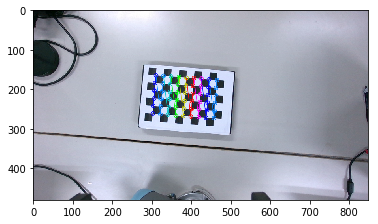

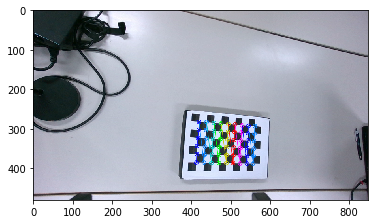

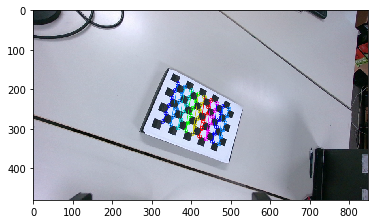

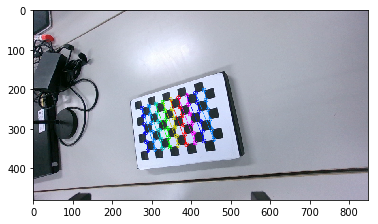

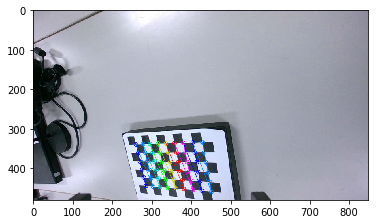

In [17]:
T_realsense = []
T_ur5 = []

for p, q in zip(calib_positions, calib_quaternions):
    img, _ = get_view(p, q)
    R, T_cam_to_chess = get_cam_R_T(img)
    T_chess_to_cam = np.linalg.inv(T_cam_to_chess)
    
    q_wxyz = [q[3], q[0], q[1], q[2]]
    T_base_to_eef = form_T(quaternion_matrix(q_wxyz)[:3, :3], p)
    
    T_realsense.append(T_chess_to_cam)
    T_ur5.append(T_base_to_eef)
    rospy.sleep(1.0)

img, _ = get_view(ROBOT_INIT_POS)

In [18]:
T_realsense

[array([[ 7.74379349e-02, -9.96956151e-01,  9.04433891e-03,
         -4.23913508e-02],
        [ 9.96997075e-01,  7.74306910e-02, -1.14889601e-03,
          4.82928343e-02],
        [ 4.45089528e-04,  9.10614758e-03,  9.99958439e-01,
         -5.37344999e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 0.07450003, -0.99278339,  0.09397283,  0.05209998],
        [ 0.96072527,  0.09671457,  0.26010238, -0.23992368],
        [-0.26731387,  0.07090444,  0.96099732, -0.49819894],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.31092952, -0.90979426,  0.27494952, -0.12904878],
        [ 0.84366486,  0.39741479,  0.36095857, -0.19708776],
        [-0.43766704,  0.11973257,  0.89112943, -0.46904669],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.17692003, -0.97277406,  0.14969946, -0.04445332],
        [ 0.90860063, -0.21989382, -0.3550938 ,  0.22422327],
        [ 0.37834402,  0.0

In [19]:
# form A, B matrix
A = []
B = []

for i, Ti in enumerate(T_ur5):
    for j, Tj in enumerate(T_ur5):
        if i==j: continue
        A.append(np.linalg.inv(Ti).dot(Tj))
        
for i, Ti in enumerate(T_realsense):
    for j, Tj in enumerate(T_realsense):
        if i==j: continue
        B.append(np.linalg.inv(Ti).dot(Tj))
        #A.append(Ti.dot(np.linalg.inv(Tj)))

A = np.array(A).transpose([1,2,0])
B = np.array(B).transpose([1,2,0])

+ Simultaneous Robot/World and Tool/Flange Calibration:    
Implementation of Shah, Mili. "Solving the robot-world/hand-eye calibration problem using the Kronecker product." 
Journal of Mechanisms and Robotics 5.3 (2013): 031007.

Batch_Processing solvesfor  X and Y in AX=YB from a set of (A,B) paired measurements.
(Ai,Bi) are absolute pose measurements with known correspondance       
A: (4x4xn) 
X: (4x4): unknown
Y: (4x4): unknown
B: (4x4xn) 
n number of measurements

+ EKF,IEKF solves for AX=XB from a set of (Ai,Bi) relative pose measurements with known correspondance.
so3 representation was used to represent the state of rotation.  

In [20]:
def get_error(T_rs_to_eef):
    error = 0
    for i in range(A.shape[-1]):
        err = np.linalg.norm(A[:,:,i].dot(T_rs_to_eef) - T_rs_to_eef.dot(B[:,:,i]))
        error += err
    return error

In [21]:
T_eef_to_rs = LeastSquaresAXXB(A.transpose([2, 0, 1]), B.transpose([2, 0, 1]), verbose=True)

print(T_eef_to_rs)
print('------------------------------')
print('Quat:', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_quat())
print('Euler(degree):', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_euler('zyx', degrees=True))
print('------------------------------')
print('Error:', get_error(T_eef_to_rs))

RotX: [[-0.99997366 -0.00127715 -0.00714497]
 [ 0.00126122 -0.99999671  0.00223391]
 [-0.0071478   0.00222484  0.99997198]]
tX: [-0.01201143  0.04688236  0.06572252]
[[-0.99997366 -0.00127715 -0.00714497 -0.01201143]
 [ 0.00126122 -0.99999671  0.00223391  0.04688236]
 [-0.0071478   0.00222484  0.99997198  0.06572252]
 [ 0.          0.          0.          1.        ]]
------------------------------
Quat: [-3.57321980e-03  1.11469690e-03  9.99992793e-01  6.34597083e-04]
Euler(degree): [ 1.79926823e+02 -4.09380300e-01 -1.27997152e-01]
------------------------------
Error: 0.39628063385246365


In [22]:
np.save('rs_extrinsic.npy', T_eef_to_rs)